<a href="https://colab.research.google.com/github/IT21238994/24-25J-169-iTranz/blob/RouteModel_IT21298394/RandomForestCombination.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1) Dataset Loaded Successfully!

2) Starting Data Preprocessing...
2) Data Preprocessing Completed!
   Final features used: ['Day', 'Hour', 'Day_Type', 'Starting_Point', 'Ending_Point', 'Traffic_Level', 'Distance (km)', 'Full Trip Time(min)', 'Seat_Availability (%)', 'Historical_Peak_Delay (min)', 'Average Speed (kmph)', 'Average Bus Stop Time(min)', 'Fare (LKR)', 'Status']

3) Training Classification Model (Predicting 'Best Route')...
   Classification Model Accuracy: 91.43%

4) Training Regression Model (Predicting 'Route Score')...
   Regression Model Mean Absolute Error: 1.40

5) Combined Model Info:
   We've trained two models:
   1) A classifier for 'Best Route' with accuracy above.
   2) A regressor for 'Route Score' with mean absolute error above.
   We'll combine them at prediction time using a weighted approach.



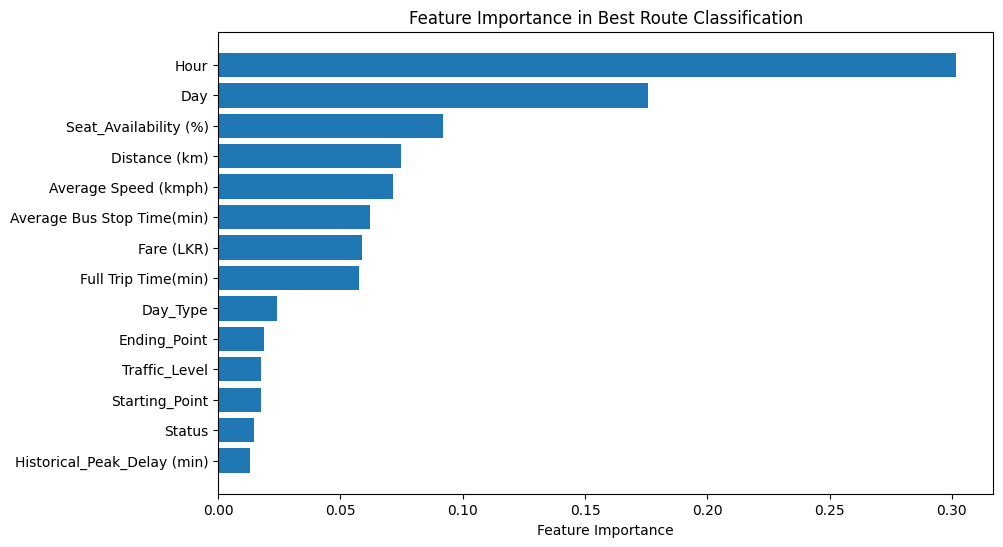

6) Models Saved Successfully!



In [6]:
#############################################
# Weighted Combination Model with Expanded Features
#############################################

# If in Colab, ensure dependencies are present
!pip install scikit-learn pandas matplotlib joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error

#############################################
# 1) Load & Preprocess the Dataset
#############################################

file_path = "bus_schedule_dataset.csv"  # Ensure your CSV is uploaded in Colab
df = pd.read_csv(file_path)
print("1) Dataset Loaded Successfully!\n")

print("2) Starting Data Preprocessing...")

# Convert 'Time' -> numeric 'Hour'
df["Hour"] = pd.to_datetime(df["Time"], format="%I:%M %p", errors="coerce").dt.hour

# Ensure numeric columns (existing + new):
numeric_cols = [
    "Distance (km)",
    "Full Trip Time(min)",
    "Seat_Availability (%)",
    "Historical_Peak_Delay (min)",
    "Delay (min)",
    "Average Speed (kmph)",          # Additional
    "Average Bus Stop Time(min)",   # Additional
    "Fare (LKR)"                    # Additional
]
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

df_agg = (
    df.groupby(["Day", "Hour", "Starting_Point", "Ending_Point"], as_index=False)["Delay (min)"]
    .idxmin()
    .rename(columns={"Delay (min)": "best_idx"})
)

# 2. For each best_idx, pick the corresponding 'Route' from df
df_agg["Best Route"] = df_agg["best_idx"].apply(
    lambda i: df.loc[i, "Route"] if pd.notna(i) else np.nan
)

# 3. Merge 'Best Route' back into your main dataframe
df = df.merge(
    df_agg.drop(columns=["best_idx"]),
    on=["Day", "Hour", "Starting_Point", "Ending_Point"],
    how="left"
)
df["Route Score"] = (
    -df["Delay (min)"]
    - df["Full Trip Time(min)"]
    + df["Seat_Availability (%)"]
)
# Handle missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Identify categorical columns
cat_cols = [
    "Day",
    "Day_Type",
    "Starting_Point",
    "Ending_Point",
    "Traffic_Level",
    "Weather",
    "Holiday",
    "Best Route",
    "Route",
    "Status"    # Additional categorical if present
]
label_encoders = {}
for col in cat_cols:
    if col in df.columns:
        df[col] = df[col].astype(str)
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Features for both classifier and regressor, now including the new numeric/categorical columns
features = [
    "Day",
    "Hour",
    "Day_Type",
    "Starting_Point",
    "Ending_Point",
    "Traffic_Level",
    "Distance (km)",
    "Full Trip Time(min)",
    "Seat_Availability (%)",
    "Historical_Peak_Delay (min)",
    "Average Speed (kmph)",
    "Average Bus Stop Time(min)",
    "Fare (LKR)",
    "Status"  # only if 'Status' was present in your dataset
    # "Weather","Holiday", etc. if needed
]

# Remove any feature that doesn't exist in the dataset
features = [col for col in features if col in df.columns]

# Targets
target_classification = "Best Route"
target_regression = "Route Score"

# Scale numeric features
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

print("2) Data Preprocessing Completed!")
print(f"   Final features used: {features}\n")

#############################################
# 2) Train Classification Model
#############################################
print("3) Training Classification Model (Predicting 'Best Route')...")
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    df[features],
    df[target_classification],
    test_size=0.2,
    random_state=42
)

classifier = RandomForestClassifier(n_estimators=200, random_state=42)
classifier.fit(X_train_class, y_train_class)

# Evaluate
y_pred_class = classifier.predict(X_test_class)
classification_accuracy = accuracy_score(y_test_class, y_pred_class)
print(f"   Classification Model Accuracy: {classification_accuracy * 100:.2f}%\n")

#############################################
# 3) Train Regression Model
#############################################
print("4) Training Regression Model (Predicting 'Route Score')...")
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    df[features],
    df[target_regression],
    test_size=0.2,
    random_state=42
)

regressor = RandomForestRegressor(n_estimators=200, random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Evaluate
y_pred_reg = regressor.predict(X_test_reg)
regression_error = mean_absolute_error(y_test_reg, y_pred_reg)
print(f"   Regression Model Mean Absolute Error: {regression_error:.2f}\n")

#############################################
# 4) Print Overall Model Info
#############################################
print("5) Combined Model Info:")
print("   We've trained two models:")
print("   1) A classifier for 'Best Route' with accuracy above.")
print("   2) A regressor for 'Route Score' with mean absolute error above.")
print("   We'll combine them at prediction time using a weighted approach.\n")

#############################################
# 5) Feature Importance Visualization (Classifier)
#############################################
feature_importance = classifier.feature_importances_
sorted_idx = np.argsort(feature_importance)
plt.figure(figsize=(10,6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align="center")
plt.yticks(range(len(sorted_idx)), [features[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.title("Feature Importance in Best Route Classification")
plt.show()

#############################################
# 6) Save Models
#############################################
joblib.dump(classifier, "bus_route_classifier.pkl")
joblib.dump(regressor, "bus_route_regressor.pkl")
joblib.dump(scaler, "scaler.pkl")
joblib.dump(label_encoders, "label_encoders.pkl")

print("6) Models Saved Successfully!\n")

#############################################
# 7) Weighted Combination Approach
#############################################

def transform_for_models(row, features, label_encoders, scaler):
    """
    Convert a single row's data into numeric form for both classifier & regressor.
    """
    input_dict = {}
    for col in features:
        # If col has a label encoder:
        if col in label_encoders:
            val_str = str(row[col])
            input_dict[col] = label_encoders[col].transform([val_str])[0]
        else:
            # numeric
            input_dict[col] = float(row[col]) if pd.notna(row[col]) else 0.0

    temp_df = pd.DataFrame([input_dict], columns=features)
    temp_scaled = scaler.transform(temp_df)
    return temp_scaled

def predict_with_combination(df_candidates, alpha=0.5):
    """
    For each candidate route in df_candidates:
      1) Classifier => predicted label
      2) Compare if candidate route matches predicted label => classifier_says_best
      3) Regressor => numeric score
      4) Weighted score = alpha*(classifier_says_best) + (1 - alpha)*(score)
    We pick the route with the highest weighted score.
    """
    results = []
    for idx, row in df_candidates.iterrows():
        row_scaled = transform_for_models(row, features, label_encoders, scaler)

        # Classifier
        pred_label = classifier.predict(row_scaled)[0]
        # decode predicted label -> route name
        pred_label_decoded = label_encoders[target_classification].inverse_transform([pred_label])[0]

        # Check if route == classifier's predicted best route
        route_str = str(row["Route"])
        try:
            route_encoded = label_encoders[target_classification].transform([route_str])[0]
            classifier_says_best = (route_encoded == pred_label)
        except:
            classifier_says_best = False

        # Regressor
        pred_score = regressor.predict(row_scaled)[0]

        # Weighted Score
        classifier_signal = 1.0 if classifier_says_best else 0.0
        weighted_score = alpha*classifier_signal + (1.0 - alpha)*pred_score

        results.append({
            "Idx": idx,
            "Route": route_str,
            "Classifier Pred Label": int(pred_label),
            "Classifier Decoded": pred_label_decoded,
            "Classifier Says Best?": classifier_says_best,
            "Regression Score": pred_score,
            "Weighted Score": weighted_score,
        })

    df_result = pd.DataFrame(results)
    best_idx = df_result["Weighted Score"].idxmax()
    best_candidate = df_result.loc[best_idx]
    return df_result, best_candidate



In [7]:

#############################################
# 8) Example usage with multiple routes
#############################################
def example_usage():
    """
    Demonstrates how to pass multiple route candidates for the same trip
    and pick the best using Weighted Combination.
    """
    print("7) Demo: Weighted Combination on manual routes...\n")
    manual_data = {
        "Date": ["01.09.2024", "01.09.2024", "01.09.2024"],
        "Time": ["7:00 AM", "7:00 AM", "7:00 AM"],
        "Route": ["138", "125", "122"],
        "Starting_Point": ["Kottawa", "Kottawa", "Kottawa"],
        "Ending_Point": ["Colombo Fort", "Colombo Fort", "Colombo Fort"],
        "Traffic_Level": ["Low", "Average", "Low"],
        "Delay (min)": [10, 1, 5],
        "Status": ["On Time", "Delayed", "Delayed"],
        "Distance (km)": [20.5, 18.0, 17.5],
        "Full Trip Time(min)": [99, 68, 92],
        "Average Speed (kmph)": [13.7, 12.5, 12.0],
        "Average Bus Stop Time(min)": [2.2, 2.0, 2.5],
        "Fare (LKR)": [76, 65, 70],
        "Seat_Availability (%)": [6, 60, 60],
        "Historical_Peak_Delay (min)": [15, 10, 8]
    }
    df_candidates = pd.DataFrame(manual_data)

    # Fill missing columns model expects
    df_candidates["Hour"] = pd.to_datetime(df_candidates["Time"], format="%I:%M %p").dt.hour
    df_candidates["Day"] = "Monday"
    df_candidates["Day_Type"] = "Weekday"
    df_candidates["Holiday"] = "No"
    df_candidates["Weather"] = "Clear"

    df_result, best_candidate = predict_with_combination(df_candidates, alpha=0.5)
    print("All Candidate Routes with Weighted Combination:\n", df_result, "\n")
    print("Final Best Route Based on Weighted Score:\n", best_candidate, "\n")

# Uncomment to run the example usage
example_usage()


7) Demo: Weighted Combination on manual routes...

All Candidate Routes with Weighted Combination:
    Idx Route  Classifier Pred Label Classifier Decoded  Classifier Says Best?  \
0    0   138                      2                138                   True   
1    1   125                      2                138                  False   
2    2   122                      2                138                  False   

   Regression Score  Weighted Score  
0          -104.700        -51.8500  
1           -26.845        -13.4225  
2           -34.085        -17.0425   

Final Best Route Based on Weighted Score:
 Idx                            1
Route                        125
Classifier Pred Label          2
Classifier Decoded           138
Classifier Says Best?      False
Regression Score         -26.845
Weighted Score          -13.4225
Name: 1, dtype: object 



/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/l

In [8]:
import pandas as pd
import numpy as np
import joblib

########################################
# 1) Load Saved Files
########################################

# Make sure these files are in the same folder or provide the correct paths
classifier = joblib.load("bus_route_classifier.pkl")
regressor = joblib.load("bus_route_regressor.pkl")
scaler = joblib.load("scaler.pkl")
label_encoders = joblib.load("label_encoders.pkl")

# For reference, define the features list exactly as in training
features = [
    "Day",
    "Hour",
    "Day_Type",
    "Starting_Point",
    "Ending_Point",
    "Traffic_Level",
    "Distance (km)",
    "Full Trip Time(min)",
    "Seat_Availability (%)",
    "Historical_Peak_Delay (min)",
    "Average Speed (kmph)",
    "Average Bus Stop Time(min)",
    "Fare (LKR)",
    "Status"
    # "Weather","Holiday", etc. if used in training
]
# Filter out any features that might not exist in your final model
# e.g., if "Status" was not actually used, remove it from the list.

target_classification = "Best Route"  # used for label_encoders
# We don't necessarily need target_regression just for testing

########################################
# 2) Weighted Combination Logic
########################################

def transform_for_models(row, features, label_encoders, scaler):
    """
    Convert a single row's data into numeric form for classifier & regressor.
    """
    input_dict = {}
    for col in features:
        # If we have a label encoder for this col:
        if col in label_encoders:
            val_str = str(row.get(col, ""))  # default to empty string if missing
            input_dict[col] = label_encoders[col].transform([val_str])[0]
        else:
            # numeric
            val = row.get(col, 0.0)
            input_dict[col] = float(val)

    temp_df = pd.DataFrame([input_dict], columns=features)
    temp_scaled = scaler.transform(temp_df)
    return temp_scaled

def predict_with_combination(df_candidates, alpha=0.5):
    """
    For each candidate route in df_candidates:
      - classifier => predicted label
      - check if candidate route matches predicted label => 1 or 0
      - regressor => numeric route score
      - Weighted Score => alpha*(classifier_says_best) + (1 - alpha)*(regressor_score)
    Return best route
    """
    results = []
    for idx, row in df_candidates.iterrows():
        row_scaled = transform_for_models(row, features, label_encoders, scaler)

        # Classifier
        pred_label = classifier.predict(row_scaled)[0]
        # decode label => best route name
        pred_label_decoded = label_encoders[target_classification].inverse_transform([pred_label])[0]

        # Check if route == classifier's predicted best route
        route_str = str(row["Route"])  # or row.get("Route", "")
        classifier_says_best = False
        if target_classification in label_encoders:
            try:
                route_encoded = label_encoders[target_classification].transform([route_str])[0]
                classifier_says_best = (route_encoded == pred_label)
            except:
                classifier_says_best = False

        # Regressor
        pred_score = regressor.predict(row_scaled)[0]

        # Weighted Score
        c_signal = 1.0 if classifier_says_best else 0.0
        weighted_score = alpha*c_signal + (1.0 - alpha)*pred_score

        results.append({
            "Idx": idx,
            "Route": route_str,
            "Classifier Pred Label": int(pred_label),
            "Classifier Decoded": pred_label_decoded,
            "Classifier Says Best?": classifier_says_best,
            "Regression Score": pred_score,
            "Weighted Score": weighted_score,
        })

    df_result = pd.DataFrame(results)
    best_idx = df_result["Weighted Score"].idxmax()
    best_candidate = df_result.loc[best_idx]
    return df_result, best_candidate

########################################
# 3) Provide Manual Candidate Routes
########################################
def main():
    # Example set of multiple routes for the same trip/time
    manual_data = {
        "Date": ["01.09.2024", "01.09.2024", "01.09.2024"],
        "Time": ["7:00 AM", "7:00 AM", "7:00 AM"],
        "Route": ["138", "125", "122"],
        "Starting_Point": ["Kottawa", "Kottawa", "Kottawa"],
        "Ending_Point": ["Colombo Fort", "Colombo Fort", "Colombo Fort"],
        "Traffic_Level": ["Low", "Average", "Low"],
        "Delay (min)": [10, 1, 5],
        "Status": ["On Time", "Delayed", "Delayed"],  # if used
        "Distance (km)": [20.5, 18.0, 17.5],
        "Full Trip Time(min)": [99, 68, 92],
        "Average Speed (kmph)": [13.7, 12.5, 12.0],
        "Average Bus Stop Time(min)": [2.2, 2.0, 2.5],
        "Fare (LKR)": [76, 65, 70],
        "Seat_Availability (%)": [6, 60, 60],
        "Historical_Peak_Delay (min)": [15, 10, 8]
    }

    df_candidates = pd.DataFrame(manual_data)

    # Fill or create columns if your model expects them
    df_candidates["Hour"] = pd.to_datetime(df_candidates["Time"], format="%I:%M %p").dt.hour
    df_candidates["Day"] = "Monday"
    df_candidates["Day_Type"] = "Weekday"
    df_candidates["Holiday"] = "No"
    df_candidates["Weather"] = "Clear"

    # Weighted combination
    df_result, best_candidate = predict_with_combination(df_candidates, alpha=0.5)

    print("Manual Testing: Weighted Combination Results:\n")
    print(df_result, "\n")

    print("Best Candidate Based on Weighted Score:\n")
    print(best_candidate, "\n")

if __name__ == "__main__":
    main()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/l

Manual Testing: Weighted Combination Results:

   Idx Route  Classifier Pred Label Classifier Decoded  Classifier Says Best?  \
0    0   138                      2                138                   True   
1    1   125                      2                138                  False   
2    2   122                      2                138                  False   

   Regression Score  Weighted Score  
0          -104.700        -51.8500  
1           -26.845        -13.4225  
2           -34.085        -17.0425   

Best Candidate Based on Weighted Score:

Idx                            1
Route                        125
Classifier Pred Label          2
Classifier Decoded           138
Classifier Says Best?      False
Regression Score         -26.845
Weighted Score          -13.4225
Name: 1, dtype: object 

